In [1]:
import Diagrams.Backend.Cairo.CmdLine

Quasifuchsian limit circles of Schottky groups of Moebius transformations. Sounds very pretentious. Connoisseurs may want to direct their monocles towards the tome ["Indra's Pearls: The Vision of Felix Klein"][book] wherein the extraordinary circumstances behind these images are revealed.

The fractals presented here are a good example why declarative image generation should be done in a full programming language.

  [book]: http://en.wikipedia.org/wiki/Indra's_Pearls_%28book%29



In [33]:
{-# LANGUAGE NoMonomorphismRestriction FlexibleContexts #-}
import Diagrams.Prelude
import qualified Data.Colour as C
import Data.Colour.SRGB (sRGB24read)

import Data.Complex as Complex
import Data.Array
import Data.Monoid

Moebius Transformations
=======================
We are dealing with complex numbers.



In [3]:
type C = Complex Double
i = 0 :+ 1

A *Moebius transformation* is a mapping of the (projective) complex plane `C` onto itself, given by a linear fractional transformation $z \to \frac{az+b}{cz+d}$.



In [4]:
data Moebius = M !C !C !C !C deriving (Eq,Show)

applyMoebius :: Moebius -> C -> C
applyMoebius (M a b c d) z = (a*z + b) / (c*z + d)

Moebius transformations form a *group*. The composition of Moebius transformations follows the well-known laws for matrix multiplcation



In [9]:
instance Semigroup Moebius where
    (M a b c d) <> (M a1 b1 c1 d1) =
        M (a*a1 + b*c1) (a*b1 + b*d1) (c*a1 + d*c1) (c*b1 + d*d1)
        
instance Monoid Moebius where
    mempty = M 1 0 0 1

and so does taking their inverse.



In [10]:
inverse :: Moebius -> Moebius
inverse (M a b c d) = M d (-b) (-c) a

Our representation of Moebius transformations has one superfluous degree of freedom: we can scale the numbers $a,b,c,d$ by a constant amount, but this will not change the transformation at all. The *determinant* of the matrix can be normalized to 1.



In [11]:
det :: Moebius -> C
det (M a b c d) = a*d - b*c

Every Moebius transformation has two fixed points. (They may be located at infinity and they may coincide.)



In [22]:
fixpoints :: Moebius -> (C,C)
fixpoints (M a b c d) = solveQuadratic c (d-a) (-b)

Moebius transformations can be classified up to conjugation by moving the fixed points to 0 and ∞. For more details, see Note 3.5 in the [book][].

The classification also gives a number called the *multiplier* associated to each Moebius transformation. Here, we only use it to find out which of the fixed points is the attractive fixpoint.



In [23]:
fixpointAttractive :: Moebius -> C
fixpointAttractive moebius@(M a b c d) =
        if Complex.magnitude multiplier >= 1 then z2 else z1
    where
    multiplier = (a-c*z1) / (a-c*z2)
    (z1,z2)    = fixpoints moebius

Schottky groups
===============
In the following, we are concerned with groups generated by two Moebius transformations `a` and `b`, so-called Schottky groups. We want to plot the set of *limit points* of this group, which is the set of points in the complex plane that is left *invariant* under the action of both `a` and `b`. This set is a fractal and it turns out that for special choices of `a` and `b`, this set is connected, like a circle. For more on this, you will have to consult the [book][].

The generators of the group are labeled with the letters `A` and `B`. `A1` corresponds to the inverse of `A`.



In [14]:
data Letter = A | B | A1 | B1 deriving (Eq,Ord,Show,Enum,Ix)
type Word   = [Letter]

The [book][] explains in box 13, page 130 that limit points correspond to infinite words. A repeating word corresponds to a fixed point of a Moebius transformation. In other words, we know how to plot some limit points, namely those that correspond to repeating words.

Moreover, words with the same initial segments tend to be close together. That allows us to plot (an approximation to) the limit set by performing a *depth first search* (DFS), exploring initial word segments and stopping when their distance becomes small.

To draw the limit set in one single stroke, we have to enumerate the DFS in the right order. This takes some thought, presented on page 182 of the [book][]. It's too long to be reproduced here, so you have to trust me on the following code.

Determine which words to explore next, in the right order



In [15]:
next A  = [B1,A,B]
next B1 = [A1,B1,A]
next A1 = [B,A1,B1]
next B  = [A,B,A1]

In [16]:
left    [a,b,c] = a
middle  [a,b,c] = b
right   [a,b,c] = c

We will seed the plot with fixed points of *commutators*, for instance `[A,B,A1,B1]`. The choice of commutator depends on the letter we are currently exploring.



In [17]:
commutatorLeft  x = take 4 $ iterate (left  . next) x
commutatorRight x = take 4 $ iterate (right . next) x

Now for the function that enumerates points in the limit set



In [24]:
limitPoints :: Double -> Moebius -> Moebius -> [C]
limitPoints eps a b = points
    where

    -- First, we need to map letters to actual group elements
    
    generators   = array (A,B1) [(A,a),(B,b),(A1,inverse a),(B1,inverse b)]
    fromLetter x = generators ! x
    fromWord     = mconcat . map fromLetter

    -- Then, we need the fixpoints of various Moebius transformations that correspond to commutators.

    mkFixpoints f = array (A,B1)
        [(x, fixpointAttractive . fromWord . f $ x) | x <- [A .. B1]]

    commutatorsLeft  = mkFixpoints commutatorLeft
    commutatorsRight = mkFixpoints commutatorRight

    pointLeft  x = commutatorsLeft  ! x
    pointRight x = commutatorsRight ! x


    -- We can now define the list of limit points

    points = concatMap (\x -> dfs mempty x $ pointRight x) [A,B,A1,B1]


    -- by performing a depth-first search

    dfs :: Moebius -> Letter -> C -> [C]
    dfs w g z =
        if Complex.magnitude (l - z) <= eps then
            [l]
        else
            let
                rs = dfs w' (right  ns) z
                ms = dfs w' (middle ns) (head rs)
                ls = dfs w' (left   ns) (head ms)
            in
                ls ++ ms ++ rs
        where
        l  = applyMoebius w $ pointLeft g
        w' = w `mappend` fromLetter g
        ns = next g

Utilities
=========
Solve a quadratic equation.



In [20]:
solveQuadratic :: Floating a => a -> a -> a -> (a,a)
solveQuadratic a b c = (x1,x2)
    where
    p2 = b/(2*a)
    q  = c/a
    x1 = -p2 + sqrt (p2*p2 - q)
    x2 = -(2*p2 + x1)


Grandma's special recipe to make two Moebius tranformations from two complex parameters. (Box 21, page 226.)



In [25]:
grandma :: C -> C -> (Moebius, Moebius)
grandma ta tb = (a,b)
    where
    tab = snd $ solveQuadratic 1 (-ta*tb) (ta*ta + tb*tb)
    z0  = (tab - 2)*tb / (tb*tab - 2*ta + 2*i*tab)
    b   = M ((tb-2*i)/2) (tb/2) (tb/2) ((tb+2*i)/2)
    ab  = M (tab/2) ((tab-2)/(2*z0)) ((tab+2)*z0/2) (tab/2)
    a   = ab `mappend` inverse b


Actual drawing
==============



In [35]:
example =
    (    make 0.01 2.5 2.5
     ||| make 0.01 (2.09) (2.09)
    ) ===
    (    make 0.004 (1.9 :+ 0.1) (2.4 :+ 0.1)
     ||| make 0.004 (2 :+ 0.2) (2 :+ (-0.2))
    )


Line 3: Redundant bracket
Found:
(2.09)
Why not:
2.09Line 3: Redundant bracket
Found:
(2.09)
Why not:
2.09

In [34]:
make eps ta tb
    = fc (sRGB24read "#DB4105") $ lw none $ pad 1.1
    $ strokeT
    $ closeTrail
    $ fromVertices [origin .+^ r2 (x,y) | x :+ y <- limitPoints eps a b]
    where (a,b) = grandma ta tb

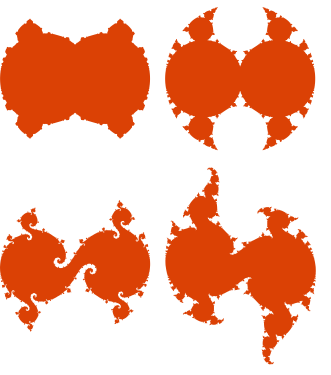

In [37]:
diagram example